In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case, timesteppers
from icedef import statoil_arcticnet_data as sd

plt.rcParams['figure.figsize'] = (6, 6)
plot_dir = './plots/'
data_dir = './data/'

In [334]:
tc = test_case.TestCaseB()
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args)
sim.results.add(tc.ref_times, tc.ref_lats.values, tc.ref_lons.values, label='reference')
sim.run_simulation(label='default')

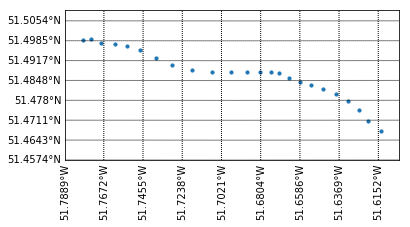

In [288]:
tc.plot_track(sizes=10)

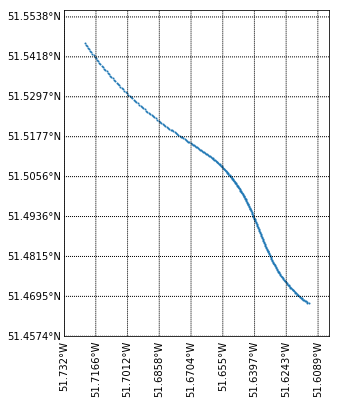

In [289]:
fig, ax = sim.results.plot(['default'])

# Optimizing Ca and Cw

### Scipy minimize

In [290]:
run_optimization = False

if not run_optimization:
    optimization_result = type('dummy', (object,), {})()
    optimization_result.x = np.array([9.15857407, 1.94167373])
    
else:
    
    keys = ['Ca', 'Cw']
    x0 = [1, 1]
    bounds = [[0.01, 15], [0.01, 15]]
    reference_vectors = [tc.ref_lats, tc.ref_lons]
    optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

optimization_result.x

array([9.15857407, 1.94167373])

In [291]:
Ca, Cw = optimization_result.x
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw}
sim.run_simulation(label='optimized', **run_sim_kwargs)

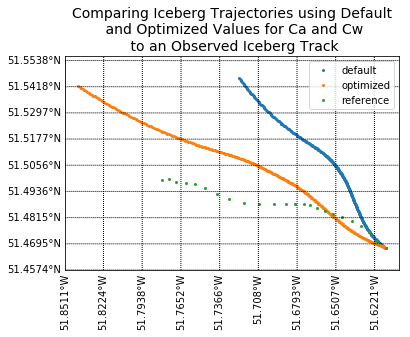

In [292]:
title = 'Comparing Iceberg Trajectories using Default\n and Optimized Values for Ca and Cw\n to an Observed Iceberg Track'
sizes = 4
legend_kwargs = {'loc': 1}
kwargs = {'title': title, 'sizes': sizes, 'legend_kwargs': legend_kwargs}
fig, ax = sim.results.plot(['default', 'optimized', 'reference'], labels=['default', 'optimized', 'reference'], 
                         **kwargs)
fig.savefig(plot_dir + 'tracks_from_default_and_optimized_Ca_and_Cw.png', bbox_inches='tight')

### Brute force

In [24]:
Ca_num = 16
Cw_num = 16
Ca_lower_bound = 0.1; Ca_upper_bound = 15
Cw_lower_bound = 0.1; Cw_upper_bound = 15

data_filename = data_dir + f'mses_for_Ca_{Ca_lower_bound}-{Ca_upper_bound}_and_Cw_{Cw_lower_bound}-{Cw_upper_bound}.npy'

try:
    mse_matrix = np.load(data_filename)

except FileNotFoundError:
    
    scaling = 'lin'

    if scaling == 'log':

        Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
        Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

    elif scaling == 'lin':

        Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
        Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


    Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

    mse_matrix = np.zeros((Ca_num, Cw_num))
    keys = ['Ca', 'Cw']
    reference_vectors = [tc.ref_lats, tc.ref_lons]

    for i in range(Ca_num):
        for j in range(Cw_num):
            form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
            mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)
            
    np.save(data_filename, mse_matrix)

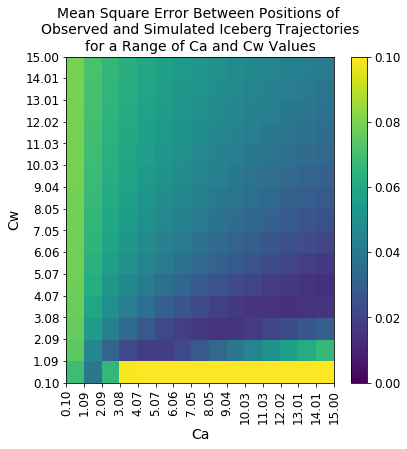

In [25]:
fig = plt.figure(figsize=(6,6))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0, vmax=0.1)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.title('Mean Square Error Between Positions of \n'+ \
          'Observed and Simulated Iceberg Trajectories\n' + \
          'for a Range of Ca and Cw Values')

plt.colorbar()

plt.show()

fig.savefig(plot_dir + 'mse_color_plot.png', bbox_inches='tight')

# Distance Between Observed and Optimized Tracks

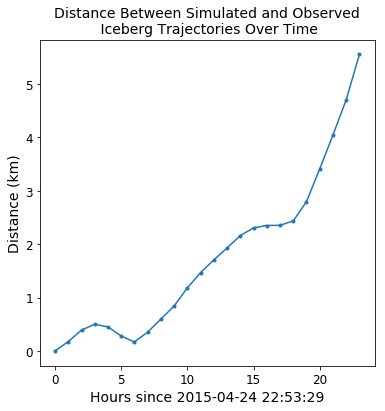

In [253]:
norms = sim.results.compute_distance_between_two_tracks('reference', 'optimized')
plt.plot(norms, '.-')
plt.ylabel('Distance (km)')
plt.xlabel('Hours since {}'.format(pd.Timestamp(tc.ref_times[0])))
plt.title('Distance Between Simulated and Observed\n Iceberg Trajectories Over Time')
plt.show()

# Varying size while using optimal drag coefficients

In [342]:
sim.time_stepper = timesteppers.rk4
sim.iceberg_size = 1000, 300 # VLG
sim.run_simulation(label='vlg_optimized', **{'Ca': Ca, 'Cw': Cw})
sim.iceberg_size = 60, 120 # MED
sim.run_simulation(label='med_optimized', **{'Ca': Ca, 'Cw': Cw})
sim.iceberg_size = 40, 80 # SM
sim.run_simulation(label='sm_optimized', **{'Ca': Ca, 'Cw': Cw})

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2591d7cba8>)

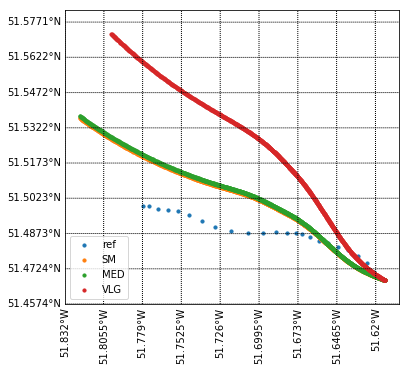

In [343]:
sim.results.plot(['reference', 'sm_optimized', 'med_optimized', 'vlg_optimized'], 
                 labels=['ref', 'SM', 'MED', 'VLG'], sizes=10)

In [337]:
keys = ['Ca', 'Cw', 'waterline_length', 'sail_height']
x0 = [1, 1, 120, 60]
#bounds = [[0.01, 15], [0.01, 15], [80, 160], [40, 80]]
bounds = [[1, 10], [1, 10], [80, 160], [40, 80]]
reference_vectors = [tc.ref_lats, tc.ref_lons]
sim.time_stepper = timesteppers.euler
sim.time_step = np.timedelta64(100, 's')
optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors, 
                                           optimizer='differential_evolution', **{'maxiter': 1})

In [338]:
optimization_result

     fun: 0.013584061209369419
     jac: array([1.49649390e-05, 2.05912544e-04, 1.38403178e-05, 0.00000000e+00])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 230
     nit: 1
 success: False
       x: array([  9.42608308,   2.46374446, 110.90713947,  56.83006815])

In [340]:
Ca, Cw, waterline_length, sail_height = optimization_result.x
kwargs = {'Ca': Ca, 'Cw': Cw, 'waterline_length': waterline_length, 'sail_height': sail_height}
sim.run_simulation(label='optimized_Ca_Cw_and_size', **kwargs)

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f25b024af98>)

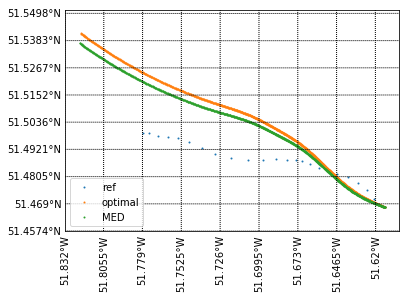

In [345]:
sim.results.plot(['reference', 'optimized_Ca_Cw_and_size', 'med_optimized'], labels=['ref', 'optimal', 'MED'])

# Sandbox

In [355]:
sim.ocean.current.directions.values[0, 0, 0]

-30.662897

In [354]:
sim.ocean.current.eastward_velocities.values[0, 0, 0]

0.6506546

In [353]:
sim.ocean.current.northward_velocities.values[0, 0, 0]

1.0974456

In [363]:
directions = sim.ocean.current.directions.values + 10
speeds = sim.ocean.current.speeds.values

In [364]:
direction = np.rad2deg(np.deg2rad(directions[0, 0, 0]) + np.pi / 2)
speed = speeds[0, 0, 0]

In [366]:
u = speed * np.cos(np.deg2rad(direction))
v = speed * np.sin(np.deg2rad(direction))

In [367]:
np.sqrt(u**2 + v**2)

1.27582848072052

In [369]:
sim.ocean.current.speeds.values[0, 0, 0]

1.2758285

In [370]:
def offset(speed=0, angle=0):

    new_directions = sim.ocean.current.directions.values + angle
    new_speeds = sim.ocean.current.speeds.values + speed
    new_eastward_velocities = new_speeds * np.cos(np.deg2rad(new_directions) + np.pi / 2)
    new_northward_velocities = new_speeds * np.sin(np.deg2rad(new_directions) + np.pi / 2)
    
    return new_eastward_velocities, new_northward_velocities

In [372]:
u

0.4502003177467943

In [373]:
offset(angle=10)

(array([[[ 0.45020032,  0.43093875,  0.4179787 , ...,  0.438895  ,
           0.41916478,  0.3982686 ],
         [ 0.43284976,  0.43855277,  0.42802754, ...,  0.39233017,
           0.38794696,  0.3758552 ],
         [ 0.37401357,  0.4153656 ,  0.42704603, ...,  0.37984952,
           0.35810402,  0.33780903],
         ...,
         [-0.05090293, -0.03895212, -0.02838066, ..., -0.09217694,
          -0.11516239, -0.13429153],
         [-0.01377866, -0.01052635, -0.00837025, ..., -0.09291591,
          -0.09935085, -0.11678267],
         [-0.01795297, -0.02021652, -0.01936861, ..., -0.17909506,
          -0.15763852, -0.16424768]],
 
        [[ 0.43800274,  0.41538137,  0.4002288 , ...,  0.4347236 ,
           0.41467538,  0.39377928],
         [ 0.42319885,  0.42674407,  0.41713807, ...,  0.38844204,
           0.3850488 ,  0.3722501 ],
         [ 0.37033856,  0.40801316,  0.42184967, ...,  0.37574926,
           0.35389775,  0.33257776],
         ...,
         [-0.04920563, -0.0371488